# 14.4 预训练word2vec
- **目录**
  - 14.4.1 跳元模型实现
    - 14.4.1.1 嵌入层
    - 14.4.1.2 定义前向传播
  - 14.4.2 跳元模型训练
    - 14.4.2.1 二元交叉熵损失
    - 14.4.2.2 初始化模型参数
    - 14.4.2.3 定义训练阶段代码
  - 14.4.3 应用词嵌入

- 本节API列表：
  - d2l.load_data_ptb：第14.3节已介绍。
  - skip_gram：实现跳元模型。
  - SigmoidBCELoss：二元交叉熵损失。
  - sigmd：Sigmoid激活函数。
  - train：使用PTB数据集和负采样方法训练跳元模型。
  - get_similar_tokens：使用词嵌入寻找最相似词元。

- 继续实现 14.1节中定义的跳元算法模型。
- 然后，在PTB数据集上使用负采样预训练word2vec。
- 首先通过调用d2l.load_data_ptb函数来获得该数据集的数据迭代器和词表，该函数在 14.3节中进行了描述。

In [16]:
%matplotlib inline
import math
import torch
from torch import nn
from d2l import torch as d2l

batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size,
                                     num_noise_words)

## 14.4.1 跳元模型实现
- 通过嵌入层和**批量矩阵乘法**实现了跳元模型。
- 首先，让我们回顾一下嵌入层是如何工作的。
### 14.4.1.1 嵌入层
- 如 9.7节中所述，嵌入层将词元的索引映射到其特征向量。
- 该层的权重是一个矩阵，其行数等于词表大小（input_dim），列数等于每个标记的向量维数（output_dim）。
- 在词嵌入模型训练之后，这个权重就是我们所需要的。

In [17]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}, '
      f'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


- 嵌入层的输入是词元（词）的索引。
- 对于任何词元索引$i$，其**向量表示**可以从嵌入层中的权重矩阵的第$i$行获得。
- 由于向量维度（`output_dim`）被设置为4，因此当小批量词元索引的形状为（2，3）时，嵌入层返回具有形状（2，3，4）的向量。
  - 此处小批量词元索引的形状为（2，3）可以理解为2个长度为3的文本序列。

In [18]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
embed(x)

tensor([[[ 0.0737, -0.2188, -0.3334, -0.1206],
         [-1.0731, -0.9273, -0.1175,  1.0488],
         [-0.8458,  0.5680,  0.4930, -1.0125]],

        [[ 1.3016,  0.1863,  0.8696, -0.2495],
         [-0.0056, -0.5139,  1.2970, -0.8920],
         [ 1.3439,  0.2100, -1.3638, -0.3406]]], grad_fn=<EmbeddingBackward0>)

### 14.4.1.2 定义前向传播
- 在前向传播中，跳元语法模型的输入包括形状为（批量大小，1）的中心词索引center和形状为（批量大小，max_len）的上下文与噪声词索引contexts_and_negatives，其中max_len在 14.3.5节中定义。
- 这两个变量首先通过嵌入层从词元索引转换成向量，然后它们的批量矩阵相乘（在 10.2.4.1节中描述）返回形状为（批量大小，1，max_len）的输出。
- 输出中的每个元素是中心词向量和上下文或噪声词向量的**点积**（即14.1节中的scores）。


In [19]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

- 让我们为一些样例输入打印此`skip_gram`函数的输出形状。

In [20]:
skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

In [21]:
## 跳元模型预测结果
skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long), embed, embed)

tensor([[[0.1790, 0.1790, 0.1790, 0.1790]],

        [[0.1790, 0.1790, 0.1790, 0.1790]]], grad_fn=<BmmBackward0>)

-----
- **说明：跳元模型的嵌入表示**

In [22]:
v = torch.ones((2, 1), dtype=torch.long)
u = torch.ones((2, 4), dtype=torch.long)
v,u

(tensor([[1],
         [1]]),
 tensor([[1, 1, 1, 1],
         [1, 1, 1, 1]]))

In [23]:
embed_v = embed(v)
embed_u = embed(u)
embed_v,embed_u

(tensor([[[ 0.0737, -0.2188, -0.3334, -0.1206]],
 
         [[ 0.0737, -0.2188, -0.3334, -0.1206]]], grad_fn=<EmbeddingBackward0>),
 tensor([[[ 0.0737, -0.2188, -0.3334, -0.1206],
          [ 0.0737, -0.2188, -0.3334, -0.1206],
          [ 0.0737, -0.2188, -0.3334, -0.1206],
          [ 0.0737, -0.2188, -0.3334, -0.1206]],
 
         [[ 0.0737, -0.2188, -0.3334, -0.1206],
          [ 0.0737, -0.2188, -0.3334, -0.1206],
          [ 0.0737, -0.2188, -0.3334, -0.1206],
          [ 0.0737, -0.2188, -0.3334, -0.1206]]], grad_fn=<EmbeddingBackward0>))

In [24]:
scores = torch.bmm(embed_v, embed_u.permute(0,2,1))

In [25]:
scores

tensor([[[0.1790, 0.1790, 0.1790, 0.1790]],

        [[0.1790, 0.1790, 0.1790, 0.1790]]], grad_fn=<BmmBackward0>)

---------

## 14.4.2 跳元模型训练

- 在训练带负采样的跳元模型之前，我们先定义它的损失函数。

### 14.4.2.1 二元交叉熵损失

- 根据 14.2.1节中负采样损失函数的定义，此处将使用二元交叉熵损失。


In [26]:
class SigmoidBCELoss(nn.Module):
    # 带掩码的二元交叉熵损失
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

- 回想一下我们在 14.3.5节中对掩码变量和标签变量的描述。
- 下面计算给定变量的二元交叉熵损失。

In [27]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

In [28]:
pred

tensor([[ 1.1000, -2.2000,  3.3000, -4.4000],
        [ 1.1000, -2.2000,  3.3000, -4.4000]])

In [29]:
## 标准化之前的损失
loss(pred, label, mask)

tensor([0.9352, 0.9231])

- 下面显示了如何使用二元交叉熵损失中的Sigmoid激活函数（以较低效率的方式）计算上述结果。
- 此处可以将这两个输出视为两个规范化的损失，在非掩码预测上进行平均。


In [30]:
def sigmd(x):
    return -math.log(1 / (1 + math.exp(-x)))

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


-----------
- **说明：binary_cross_entropy_with_logits函数用法**
  - 标准二元交叉熵（BCE）。传统的二元交叉熵损失需要**先手动应用Sigmoid**，再计算损失：
    $$
\ell(x, y) = -[y \cdot \log(\sigma(x)) + (1-y) \cdot \log(1-\sigma(x))]
    $$
  -  BCE with_logits 的改进。`binary_cross_entropy_with_logits` **合并了Sigmoid和BCE**，直接对Logits计算损失：
    $$
\ell(x, y) = \max(x, 0) - x \cdot y + \log(1 + e^{-|x|})
    $$
  - 前两种公式在数学上是等价的，但后者实现了数值稳定。
  - 所谓logits是指：
    - 模型最后一层的原始输出（未经过Softmax或Sigmoid等激活函数）。
    - 物理意义：表示模型对某类别的**未归一化置信度分数**（无概率意义）。
  

In [31]:
# 标准二元交叉熵
l = - (label * torch.log(torch.sigmoid(pred)) + (1 - label) * torch.log(1 - torch.sigmoid(pred))) * mask
# l是上下文词与噪声词各自的损失，然后求均值，最后通过掩码进行标准化
l, l.mean(1), l.mean(1) * mask.shape[1] / mask.sum(axis=1)

(tensor([[0.2873, 0.1051, 3.3362, 0.0122],
         [1.3873, 2.3051, 0.0000, 0.0000]]),
 tensor([0.9352, 0.9231]),
 tensor([0.9352, 1.8462]))

In [32]:
# BCE with_logits的用法
l1 = (torch.maximum(pred, torch.tensor(0)) - pred * label + torch.log(1 + torch.exp(- torch.abs(pred)))) * mask
l1, l1.mean(1), l1.mean(1) * mask.shape[1] / mask.sum(axis=1)

(tensor([[0.2873, 0.1051, 3.3362, 0.0122],
         [1.3873, 2.3051, 0.0000, 0.0000]]),
 tensor([0.9352, 0.9231]),
 tensor([0.9352, 1.8462]))

In [33]:
# 注意pytorch的maximum与max的区别
torch.maximum(pred,torch.tensor(0))

tensor([[1.1000, 0.0000, 3.3000, 0.0000],
        [1.1000, 0.0000, 3.3000, 0.0000]])

-------------

### 14.4.2.2 初始化模型参数
- 定义了两个嵌入层，将词表中的所有单词分别作为中心词和上下文词使用。
- 字向量维度`embed_size`被设置为100。


In [34]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size))

### 14.4.2.3 定义训练阶段代码
- 训练阶段代码实现定义如下：
  - 由于填充的存在，损失函数的计算与以前的训练函数略有不同。


In [36]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(m):
        if type(m) == nn.Embedding:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    # 规范化的损失之和，规范化的损失数
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]

            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

- 现在使用负采样来训练跳元模型。


loss 0.410, 63246.3 tokens/sec on cuda:0


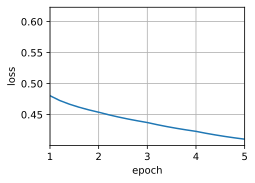

In [38]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

-----
- **说明：训练代码的异常情况处理**
  - 运行下述训练代码如发生如下异常则需要修改d2l包的代码：
  <img src= '../img/14_4_1.png'>
  - 修改d2l包原代码torch.py如下：
  <img src= '../img/14_4_2.png'>
-----

## 14.4.3 应用词嵌入
- 在训练word2vec模型之后，可以使用训练好模型中词向量的余弦相似度来从词表中找到与输入单词语义最相似的单词。

In [39]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # 计算余弦相似性。增加1e-9以获得数值稳定性
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # 删除输入词
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

get_similar_tokens('chip', 3, net[0])

cosine sim=0.657: chips
cosine sim=0.640: computer
cosine sim=0.635: intel


------------
- **说明：余弦相似度计算过程**

In [27]:
## 取出输入词的词向量
W= net[0].weight.data
x = W[vocab['chip']]
x

tensor([ 0.0918,  0.1140, -0.0390,  0.2982,  0.2008,  0.2827, -0.1701, -0.1854,
         0.2623, -0.1377,  0.2276,  0.0897,  0.4376, -0.1839,  0.4312, -0.3196,
         0.3250, -0.5122,  0.1218, -0.0290, -0.0295, -0.0263,  0.0714, -0.0325,
         0.0656,  0.2211, -0.1697,  0.5606, -0.1080,  0.1746, -0.1441, -0.0341,
        -0.3194, -0.1385,  0.0948, -0.1403, -0.1825, -0.2198, -0.4442, -0.3939,
        -0.1670,  0.4267,  0.6417, -0.5120, -0.0319,  0.1544, -0.2931,  0.0914,
        -0.1577, -0.5156, -0.4056, -0.3737,  0.0612, -0.3462,  0.4478, -0.3362,
         0.4079,  0.3295, -0.4782,  0.4221,  0.2959,  0.4326,  0.1585,  0.4729,
         0.3193, -0.2767, -0.3471,  0.5146,  0.0281,  0.2781, -0.0617, -0.3638,
        -0.0741, -0.1126,  0.4204,  0.1865,  0.3513,  0.1955, -0.2949, -0.1272,
        -0.2199,  0.0306,  0.2321, -0.5606,  0.0894, -0.1934, -0.4692, -0.1558,
        -0.1431, -0.1040,  0.0062, -0.1807,  0.2782, -0.1771,  0.2660, -0.1077,
        -0.9164,  0.7099,  0.4188, -0.18

In [28]:
# 将输入词的词向量与其他词向量计算余弦相似度
cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
cos

tensor([-0.1052,  0.0576, -0.0091,  ...,  0.3856,  0.2646,  0.2006],
       device='cuda:0')

In [33]:
## 取出相似度最大的前3个词元
k = 3
topk = torch.topk(cos, k=k+1)
for i in topk[1][1:].cpu().numpy().astype('int32'):
    print(f'{vocab.idx_to_token[i]}: {cos[i]:.3f}')

workstations: 0.687
microprocessor: 0.676
chips: 0.656


In [34]:
# torch的topk函数返回值的整体面貌
topk

torch.return_types.topk(
values=tensor([1.0000, 0.6868, 0.6763, 0.6560], device='cuda:0'),
indices=tensor([2084, 5564, 6084, 1583], device='cuda:0'))

In [26]:
topk[1][1:]

tensor([6084, 2113, 1583], device='cuda:0')

---------

## 小结

* 我们可以使用嵌入层和二元交叉熵损失来训练带负采样的跳元模型。
* 词嵌入的应用包括基于词向量的余弦相似度为给定词找到语义相似的词。